# Qualitative Analysis of Seizure Onset and Spread

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from itertools import chain
import scipy as sc
from bct.algorithms import community_louvain
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
from krippendorff import alpha
import pingouin as pg

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

## Workspace Preparation

In [2]:
# Loading patient level metadata
metadata = pd.read_csv('../metadata_wchreject.csv')
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'

In [3]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
figpath = CONFIG["paths"]["FIGURES"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
pt_table = pd.DataFrame(CONFIG["patients"]).sort_values('ptID')
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = pt_table.ptID.to_numpy()
lf_pt_list = pt_list[pt_table.lf_stim==1]

In [4]:
# Loading seizure level metadata
sz_metadata = pd.read_csv(ospj(datapath,'stim_seizure_information - Revised_seizure_annotation.csv'))
sz_metadata.replace({np.nan:pd.NA},inplace=True)

## Seizure Annotations

#### Preparing annotation table

In [5]:
def spread_inclusion(row):
    for ch in row['UEO_ch']:
        if ch not in row['10sec_ch']:
            row['10sec_ch'].append(ch)
    return row

In [6]:
annotators = np.sort(['EC','CK','DZ','JJ','JK'])
time_labels = ['EEC_time','UEO_time','spread_time']
clinician_tables = {}
for clin in annotators:
    clinician_tables[clin] = pd.read_csv(ospj(datapath,f"stim_seizure_information - {clin}_annotation_demo.csv"))
combined_df = pd.concat(clinician_tables.values(), keys=clinician_tables.keys(), names=['Clinician'])

# Reset index to avoid having MultiIndex
combined_df.reset_index(inplace=True)

# Create a unique identifier for each seizure
combined_df['Seizure_ID'] = combined_df.groupby(['Patient', 'Clinician']).cumcount() + 1
combined_df['Seizure_ID'] = combined_df['Patient'] + '_' + combined_df['Seizure_ID'].astype(str)
combined_df = combined_df.drop(['level_1'],axis=1)

# Drop nan rows
combined_df = combined_df.dropna(axis=0,how='any',subset=['EEC_ch','UEO_ch'])

# Turning strings of channels to a list
combined_df['EEC_ch'] = combined_df['EEC_ch'].str.split(',')
combined_df['UEO_ch'] = combined_df['UEO_ch'].str.split(',')
combined_df['10sec_ch'] = combined_df['10sec_ch'].str.split(',')
combined_df['spread_ch'] = combined_df['spread_ch'].str.split(',')


# Add UEO channels to 10 second spread
combined_df = combined_df.apply(spread_inclusion,axis=1)
combined_df.head(5)

,Clinician,Patient,IEEGname,Onset,end,stim,stim_channels,EEC_time,EEC_ch,UEO_time,UEO_ch,10sec_ch,spread_time,spread_ch,Seizure_ID
0,CK,HUP235,HUP235_phaseII,17776.0500,17842.51,1.0,LA4-LA5,17776.00,"[LI1, LI2, LI3, LA1, LA2, LA3, LB1, LB2, LB3, ...",17777.25,"[LI1, LI2, LI3, LA1, LA2, LA3, LB1, LB2, LB3, ...","[LI1, LI2, LI3, LA1, LA2, LA3, LA4, LA5, LB1, ...",17778.26,"[LB5, LA4, LA5]",HUP235_1.0
1,CK,HUP235,HUP235_phaseII,107374.2078,107391.19,0.0,NaN,107372.02,"[LB3, LC1]",107374.73,"[LB3, LC1]","[LB2, LB3, LB4, LC1, LC2]",107383.66,"[LB2, LB4, LC2]",HUP235_2.0
2,CK,HUP235,HUP235_phaseII,126735.8514,126757.97,0.0,NaN,126735.83,"[LB3, LC1]",126735.83,[LC1],"[LB2, LB3, LB4, LC1, LC2]",126739.63,"[LB2, LB3, LB4, LC2]",HUP235_3.0
3,CK,HUP235,HUP235_phaseII,497084.3746,497216.20,0.0,NaN,497084.31,"[LB3, LC1]",497084.31,[LC1],"[LB2, LB3, LB4, LC1, LC2]",497087.62,[LB3],HUP235_4.0
5,CK,HUP238,HUP238_phaseII,10640.8600,10792.34,1.0,LC2-LC3,10653.02,"[LA1, LB1, LB2, LC1, LC2, LC3, LI1]",10653.02,"[LB1, LB2, LC1, LC2, LC3]","[LA1, LB1, LB2, LC1, LC2, LC3, LI1]",10661.10,"[LA1, LI1]",HUP238_1.0


In [7]:
# Combining annotations across a patient at the channel level
def combine_ch_annots(group):
    ret = {"clinician": [],
           "patient": [],
           "eec": [],
           "eec_time": [],
           "ueo": [],
           "ueo_time": [],
           "sec": [],
           "spread": []}    
    group.sort_values(by='Clinician',inplace=True)
    group['IEEGname'] = group['IEEGname'].fillna(method='ffill').fillna(method='bfill')
    ieeg_name = group['IEEGname'].iloc[0]
    pt = group['Patient'].iloc[0]

    # Get all channels
    with open('woj_ieeglogin.bin', 'r') as f:
        session = Session('wojemann', f.read())
    ds = session.open_dataset(ieeg_name)
    raw_labels = clean_labels(ds.get_channel_labels(),pt)
    
    all_chs = [l for l in raw_labels if l not in ['Cz','Fz','C03','C04','EKG01','EKG02','ROC','LOC']]
    # group.[group.isna()] = []
    for _,row in group.iterrows():
        for i,v in row.items():
            if not isinstance(v,list):
                if pd.isna(v):
                    row[i] = []
        ret["clinician"].append(row.Clinician)
        ret["patient"] = row.Patient
        ret["eec"].append([l in clean_labels(row.EEC_ch,pt) for l in all_chs])
        ret["ueo"].append([l in clean_labels(row.UEO_ch,pt) for l in all_chs])
        ret["sec"].append([l in clean_labels(row["10sec_ch"],pt) for l in all_chs])
        ret["spread"].append([l in clean_labels(row.spread_ch,pt) for l in all_chs])
        ret["eec_time"].append(row.EEC_time)
        ret["ueo_time"].append(row.UEO_time)
    ret["all_chs"] = all_chs
    ret["iEEG_ID"] = row["IEEGname"]
    ret["offset"] = row["end"]
    ret["stim"] = row["stim"]
        
    return pd.Series(ret)


In [8]:
combined_annots = combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index()

### Annotator evaluation

#### Cohen's Kappa

In [9]:
# Calculate the kappa value between each pair of clinicians for each patient
ANNOT_ALL_SZ = {i:[] for i in range(len(annotators))}
def pairwise_kappa(row):
    row_idxs = [i for i in row.index if i in ["eec","ueo","sec","spread"]]
    for ch_type in row_idxs:
        all_kappas = np.ones((len(row[ch_type]),len(row[ch_type])))*2
        chs = row[ch_type]
        for i in range(len(chs)):
            for j in range(i+1,len(chs)):
                all_kappas[i,j] = cohen_kappa_score(chs[i],chs[j])
                if ch_type == 'ueo':
                    ANNOT_ALL_SZ[i].append(all_kappas[i,j])
                    ANNOT_ALL_SZ[j].append(all_kappas[i,j])
        # plt.figure()
        # sns.heatmap(all_kappas,annot=True,fmt=".2f",cmap="magma",xticklabels=row.clinician,yticklabels=row.clinician,vmin=0,vmax=1)
        # plt.title(f"{row.name}: {ch_type}")
        row[f"{ch_type}_kappas"] = all_kappas

    return row

kappa_annots = combined_annots.apply(pairwise_kappa,axis=1).reset_index()

(0.0, 1.1)

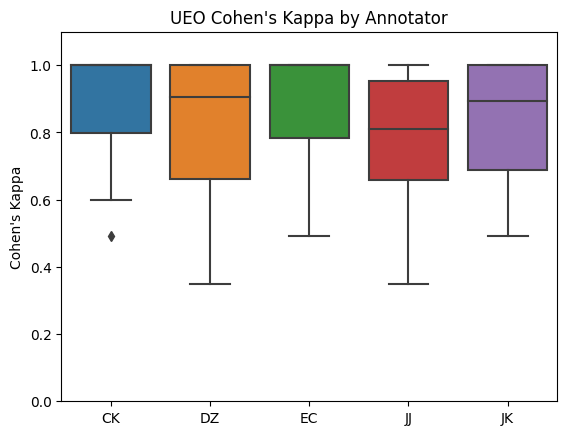

In [10]:
sns.boxplot(pd.DataFrame(ANNOT_ALL_SZ))
plt.xticks(np.arange(len(annotators)),annotators)
plt.title("UEO Cohen's Kappa by Annotator")
plt.ylabel('Cohen\'s Kappa')
plt.ylim([0,1.1])

In [11]:
kappa_annots.head()

,index,Seizure_ID,clinician,patient,eec,eec_time,ueo,ueo_time,sec,spread,all_chs,iEEG_ID,offset,stim,eec_kappas,ueo_kappas,sec_kappas,spread_kappas
0,0,HUP235_1.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[True, True, True, False, False, False, False...","[17776.0, 17776.06, 17776.07, 17776.0, 17776.03]","[[True, True, True, False, False, False, False...","[17777.25, 17777.28, 17777.31, 17777.34, 17777...","[[True, True, True, True, True, False, False, ...","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,17842.51,1.0,"[[2.0, 0.8616290480863592, 0.9538763493621197,...","[[2.0, 0.9567617295308187, 1.0, 0.953876349362...","[[2.0, 0.621222296843519, 0.9632525410476935, ...","[[2.0, 0.06117353308364537, 0.7947598253275109..."
1,1,HUP235_2.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[107372.02, 107374.73, 107372.67, 107372.64, 1...","[[False, False, False, False, False, False, Fa...","[107374.73, 107379.47, 107375.0, 107374.75, 10...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,107391.19,0.0,"[[2.0, 1.0, 0.6618705035971223, 0.661870503597...","[[2.0, 0.6618705035971223, 1.0, 0.661870503597...","[[2.0, 0.6933115823817292, 1.0, 0.788764044943...","[[2.0, 0.25867507886435337, 0.7947598253275109..."
2,2,HUP235_3.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[126735.83, 126735.84, 126735.39, 126735.81, 1...","[[False, False, False, False, False, False, Fa...","[126735.83, 126739.617, 126739.6, 126739.61, 1...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,126757.97,0.0,"[[2.0, 0.6618705035971223, 0.38427947598253276...","[[2.0, 0.6618705035971223, 1.0, 1.0, 0.4918918...","[[2.0, 0.7530647985989491, 0.8223062381852552,...","[[2.0, 0.8833746898263027, 1.0, 0.389610389610..."
3,3,HUP235_4.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[497084.31, 497084.27, 497083.89, 497083.87, 4...","[[False, False, False, False, False, False, Fa...","[497084.31, 497084.27, 497084.32, 497084.29, 4...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,497216.20,0.0,"[[2.0, 1.0, 0.3088235294117646, 0.308823529411...","[[2.0, 1.0, 1.0, 1.0, 1.0], [2.0, 2.0, 1.0, 1....","[[2.0, 1.0, 1.0, 0.8833746898263027, 1.0], [2....","[[2.0, 0.38961038961038963, 1.0, 0.49189189189..."
4,4,HUP238_1.0,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, True, False, False, Fal...","[10653.02, 10653.16, 10641.25, 10653.04, 10641...","[[False, False, False, False, False, False, Fa...","[10653.02, 10653.16, 10652.98, 10653.04, 10653...","[[False, False, False, True, False, False, Fal...","[[False, False, False, True, False, False, Fal...","[F04, F08, Fp02, LA01, LA02, LA03, LA04, LA05,...",HUP238_phaseII,10792.34,1.0,"[[2.0, 0.4790874524714829, 0.24029574861367842...","[[2.0, 1.0, 1.0, 0.9053213545266068, 0.8851634...","[[2.0, 0.9294904786412763, 0.9192692987625221,...","[[2.0, 0.6633906633906634, 0.6633906633906634,..."


##### Grouping by annotation type

In [12]:
def annot_level_tensors(col):
    num_seizures = len(col)
    num_annot = col.iloc[0].shape[0]
    ch_tensor = np.zeros((num_seizures,int(num_annot*(num_annot+1)/2-num_annot)))
    for i, row in col.items():
        ch_tensor[i,:] = row[row != 2]
    return ch_tensor.flatten()

Text(0.5, 1.0, 'Overall Annotation Distributions')

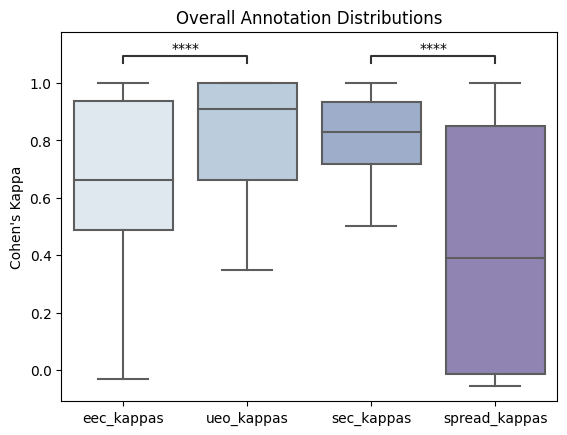

In [13]:
extracted_kappas = kappa_annots[[c for c in kappa_annots.columns if 'kappas' in c]].apply(annot_level_tensors,axis=0)
sns.set_palette('BuPu')
ax = sns.boxplot(extracted_kappas)
add_stat_annotation(ax,data=extracted_kappas,box_pairs=(("eec_kappas","ueo_kappas"),("sec_kappas","spread_kappas")),test='Mann-Whitney',loc='inside',verbose=0)
plt.ylabel('Cohen\'s Kappa')
plt.title('Overall Annotation Distributions')

##### Grouping by clinician and annotation type

In [14]:
# Getting all annots for each annot type combined into a tensor
all_seizures = []
for i,row in kappa_annots[[c for c in kappa_annots.columns if 'kappas' in c]].iterrows():
    # print(np.stack(row.to_numpy().tolist(),ax is=2).shape)
    temp = np.stack(row.to_numpy().tolist(),axis=2)
    temp[temp==2] = np.nan
    all_seizures.append(temp)
all_seizures = np.stack(all_seizures,axis=3)

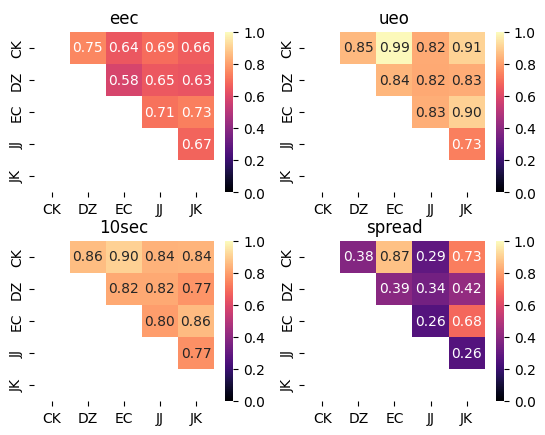

In [15]:
# plotting the mean agreement per person per annotation type
all_seizure_means = np.mean(all_seizures,3)
titles = ["eec","ueo","10sec","spread"]
fig,axs = plt.subplots(2,2)
plt.subplots_adjust(hspace=.3)
for k in range(all_seizure_means.shape[2]):
    ax_idxs = np.unravel_index(k,(2,2))
    ax = axs[ax_idxs[0],ax_idxs[1]]
    sns.heatmap(all_seizure_means[:,:,k],annot=True,fmt=".2f",cmap="magma",xticklabels=annotators,yticklabels=annotators,vmin=0,vmax=1,ax=ax)
    ax.set_title(titles[k])

##### Seizure heatmap

In [16]:
def sz_level_agreement(row):
    row_idxs = [i for i in row.index if 'kappas' in i]
    for chtype in row_idxs:
        row[f"{chtype[:-7]}_avg"] = np.mean(row[chtype][row[chtype] != 2])
    return row
kappa_avg = kappa_annots.apply(sz_level_agreement,axis=1)
kappa_avg.head()
# hard code the columns that this can be applied to (eec, ueo, sec,spread)

,index,Seizure_ID,clinician,patient,eec,eec_time,ueo,ueo_time,sec,spread,...,offset,stim,eec_kappas,ueo_kappas,sec_kappas,spread_kappas,eec_avg,ueo_avg,sec_avg,spread_avg
0,0,HUP235_1.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[True, True, True, False, False, False, False...","[17776.0, 17776.06, 17776.07, 17776.0, 17776.03]","[[True, True, True, False, False, False, False...","[17777.25, 17777.28, 17777.31, 17777.34, 17777...","[[True, True, True, True, True, False, False, ...","[[False, False, False, True, True, False, Fals...",...,17842.51,1.0,"[[2.0, 0.8616290480863592, 0.9538763493621197,...","[[2.0, 0.9567617295308187, 1.0, 0.953876349362...","[[2.0, 0.621222296843519, 0.9632525410476935, ...","[[2.0, 0.06117353308364537, 0.7947598253275109...",0.915665,0.945513,0.719358,0.243112
1,1,HUP235_2.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[107372.02, 107374.73, 107372.67, 107372.64, 1...","[[False, False, False, False, False, False, Fa...","[107374.73, 107379.47, 107375.0, 107374.75, 10...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...",...,107391.19,0.0,"[[2.0, 1.0, 0.6618705035971223, 0.661870503597...","[[2.0, 0.6618705035971223, 1.0, 0.661870503597...","[[2.0, 0.6933115823817292, 1.0, 0.788764044943...","[[2.0, 0.25867507886435337, 0.7947598253275109...",0.797122,0.797122,0.743239,0.323239
2,2,HUP235_3.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[126735.83, 126735.84, 126735.39, 126735.81, 1...","[[False, False, False, False, False, False, Fa...","[126735.83, 126739.617, 126739.6, 126739.61, 1...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...",...,126757.97,0.0,"[[2.0, 0.6618705035971223, 0.38427947598253276...","[[2.0, 0.6618705035971223, 1.0, 1.0, 0.4918918...","[[2.0, 0.7530647985989491, 0.8223062381852552,...","[[2.0, 0.8833746898263027, 1.0, 0.389610389610...",0.510981,0.725605,0.792176,0.695532
3,3,HUP235_4.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[497084.31, 497084.27, 497083.89, 497083.87, 4...","[[False, False, False, False, False, False, Fa...","[497084.31, 497084.27, 497084.32, 497084.29, 4...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...",...,497216.20,0.0,"[[2.0, 1.0, 0.3088235294117646, 0.308823529411...","[[2.0, 1.0, 1.0, 1.0, 1.0], [2.0, 2.0, 1.0, 1....","[[2.0, 1.0, 1.0, 0.8833746898263027, 1.0], [2....","[[2.0, 0.38961038961038963, 1.0, 0.49189189189...",0.537831,1.000000,0.953350,0.428411
4,4,HUP238_1.0,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, True, False, False, Fal...","[10653.02, 10653.16, 10641.25, 10653.04, 10641...","[[False, False, False, False, False, False, Fa...","[10653.02, 10653.16, 10652.98, 10653.04, 10653...","[[False, False, False, True, False, False, Fal...","[[False, False, False, True, False, False, Fal...",...,10792.34,1.0,"[[2.0, 0.4790874524714829, 0.24029574861367842...","[[2.0, 1.0, 1.0, 0.9053213545266068, 0.8851634...","[[2.0, 0.9294904786412763, 0.9192692987625221,...","[[2.0, 0.6633906633906634, 0.6633906633906634,...",0.416368,0.916419,0.906099,0.596564


Text(0.5, 1.0, "Average Cohen's Kappa per Seizure")

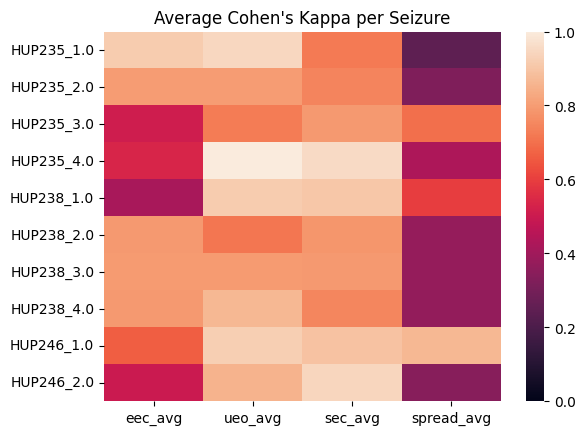

In [17]:
sns.heatmap(kappa_avg.iloc[:,-4:],yticklabels=kappa_avg.Seizure_ID,vmin=0,vmax=1)
plt.title("Average Cohen\'s Kappa per Seizure")

#### ICC

In [18]:
def detrend(group,label='UEO_time'):
    group[label] = group[label] - group[label].min()
    return group
for label in time_labels:
    combined_df = combined_df.groupby('Seizure_ID').apply(detrend,label=label).reset_index(drop=True)

In [19]:

all_iccs = np.zeros((4,len(time_labels)))
for i,label in enumerate(time_labels):
    icc = pg.intraclass_corr(data=combined_df,targets='Seizure_ID',raters='Clinician',ratings=label)
    all_iccs[0,i] = icc.loc[2,'ICC']
    all_iccs[[1,2],i] = icc.loc[2,'CI95%']
    all_iccs[3,i] = icc.loc[2,'pval']

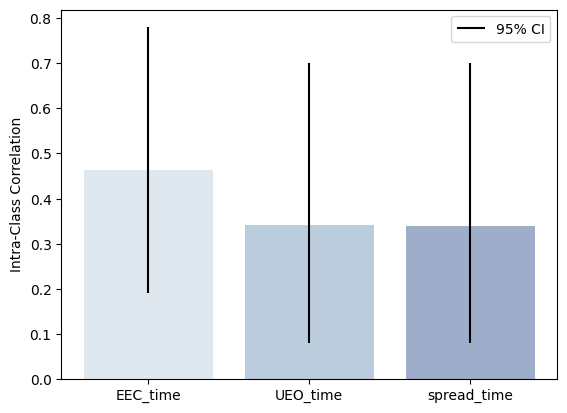

In [20]:
sns.barplot(x=np.arange(len(time_labels)),y=all_iccs[0,:])
plt.xticks(np.arange(3),time_labels);
plt.ylabel('Intra-Class Correlation');
lc = plt.vlines(np.arange(3),all_iccs[1,:],all_iccs[2,:],linestyles='solid',colors='black')
lc.set_label('95% CI')
plt.legend()

#### Krippendorff Alpha

In [21]:
def combine_time_annots(group):
    ret = {"clinician": [],
           "patient": [],
           "eec": [],
           "ueo": [],
           "spread": []}    
    group.sort_values(by='Clinician',inplace=True)

    # Get all channels
    for _,row in group.iterrows():
        ret["clinician"].append(row.Clinician)
        ret["patient"] = row.Patient
        ret["eec"].append(row.EEC_time)
        ret["ueo"].append(row.UEO_time)
        ret["spread"].append(row.spread_time)
    return pd.Series(ret)
    

In [22]:
combined_time_annots = combined_df.groupby('Seizure_ID').apply(combine_time_annots).reset_index()
combined_time_annots.head()

,Seizure_ID,clinician,patient,eec,ueo,spread
0,HUP235_1.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[0.0, 0.06000000000130967, 0.06999999999970896...","[0.0, 0.029999999998835847, 0.0600000000013096...","[0.0, 0.18000000000029104, 1.7100000000027649,..."
1,HUP235_2.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[0.05000000000291038, 2.7599999999947613, 0.69...","[0.0, 4.740000000005239, 0.27000000000407454, ...","[1.110000000000582, 1.4899999999906868, 0.0, 0..."
2,HUP235_3.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[0.47000000000116415, 0.47999999999592546, 0.0...","[0.0, 3.786999999996624, 3.7700000000040745, 3...","[0.0, 5.1599999999889405, 5.139999999999418, 1..."
3,HUP235_4.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[0.4400000000023283, 0.40000000002328306, 0.02...","[0.03999999997904524, 0.0, 0.04999999998835847...","[0.0, 5.75, 4.400000000023283, 3.25, 2.2399999..."
4,HUP238_1.0,"[CK, DZ, EC, JJ, JK]",HUP238,"[11.81000000000131, 11.950000000000728, 0.0400...","[0.040000000000873115, 0.18000000000029104, 0....","[8.1200000000008, 5.300000000001091, 0.0, 8.22..."


In [23]:
# alpha(np.stack(combined_time_annots.iloc[:,3].to_numpy()).T)
all_alphas = []
all_pts = []
for _,g in combined_time_annots.groupby('patient'):
    temp_alphas = []
    for c in range(3,g.shape[1]):
        # print(alpha(np.stack(g.iloc[:,c]).T))
        temp_alphas.append(alpha(np.stack(g.iloc[:,c]).T))
    all_alphas.append(np.array(temp_alphas))
    all_pts.append(g.iloc[0,2])
# pd.DataFrame(np.array(all_alphas),columns=['eec','ueo','spread'])

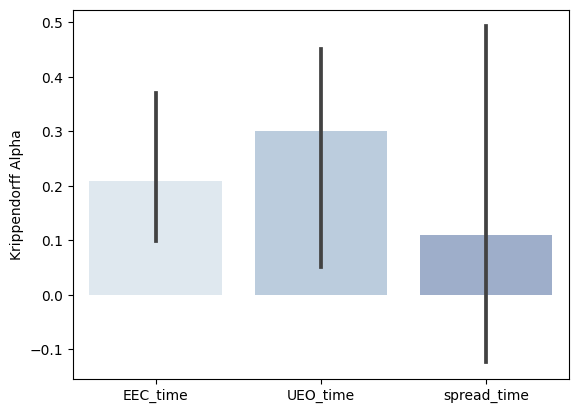

In [24]:
sns.barplot(all_alphas)
plt.ylabel('Krippendorff Alpha')
plt.xticks(np.arange(3),time_labels);

### Annotation consensus

In [25]:
def create_consensus(row):
    for key in ["eec","ueo","sec"]:
        row[f"{key}_consensus"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 2).astype(bool)
        if key is not "sec":
            row[f"{key}_time_consensus"] = np.median(row[f"{key}_time"])
    return row

In [26]:
consensus_annots = combined_annots.apply(create_consensus,axis=1)
consensus_annots.head()

,Seizure_ID,clinician,patient,eec,eec_time,ueo,ueo_time,sec,spread,all_chs,iEEG_ID,offset,stim,eec_consensus,eec_time_consensus,ueo_consensus,ueo_time_consensus,sec_consensus
0,HUP235_1.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[True, True, True, False, False, False, False...","[17776.0, 17776.06, 17776.07, 17776.0, 17776.03]","[[True, True, True, False, False, False, False...","[17777.25, 17777.28, 17777.31, 17777.34, 17777...","[[True, True, True, True, True, False, False, ...","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,17842.51,1.0,"[True, True, True, False, False, False, False,...",17776.03,"[True, True, True, False, False, False, False,...",17777.28,"[True, True, True, True, True, False, False, F..."
1,HUP235_2.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[107372.02, 107374.73, 107372.67, 107372.64, 1...","[[False, False, False, False, False, False, Fa...","[107374.73, 107379.47, 107375.0, 107374.75, 10...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,107391.19,0.0,"[False, False, False, False, False, False, Fal...",107372.64,"[False, False, False, False, False, False, Fal...",107375.00,"[False, False, False, False, False, False, Fal..."
2,HUP235_3.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[126735.83, 126735.84, 126735.39, 126735.81, 1...","[[False, False, False, False, False, False, Fa...","[126735.83, 126739.617, 126739.6, 126739.61, 1...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,126757.97,0.0,"[False, False, False, False, False, False, Fal...",126735.81,"[False, False, False, False, False, False, Fal...",126739.60,"[True, False, False, False, False, False, Fals..."
3,HUP235_4.0,"[CK, DZ, EC, JJ, JK]",HUP235,"[[False, False, False, False, False, False, Fa...","[497084.31, 497084.27, 497083.89, 497083.87, 4...","[[False, False, False, False, False, False, Fa...","[497084.31, 497084.27, 497084.32, 497084.29, 4...","[[False, False, False, False, False, False, Fa...","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP235_phaseII,497216.20,0.0,"[True, True, True, False, False, False, False,...",497084.27,"[False, False, False, False, False, False, Fal...",497084.31,"[False, False, False, False, False, False, Fal..."
4,HUP238_1.0,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, True, False, False, Fal...","[10653.02, 10653.16, 10641.25, 10653.04, 10641...","[[False, False, False, False, False, False, Fa...","[10653.02, 10653.16, 10652.98, 10653.04, 10653...","[[False, False, False, True, False, False, Fal...","[[False, False, False, True, False, False, Fal...","[F04, F08, Fp02, LA01, LA02, LA03, LA04, LA05,...",HUP238_phaseII,10792.34,1.0,"[False, False, False, True, False, False, Fals...",10653.02,"[False, False, False, False, False, False, Fal...",10653.04,"[False, False, False, True, False, False, Fals..."


In [27]:
# Saving the annotation table to a csv
consensus_annots.to_csv(ospj(prodatapath,"consensus_annots.csv"),index=False)

## Model Evaluation

### Annotation demo

In [28]:
model_annotators = np.array(['EC','CK','DZ','JJ','JK','MDL'])
model_annotators.sort()

In [29]:
model_annots = pd.read_csv(ospj(prodatapath,"annotation_demo_algorithm.csv"))
model_annots = model_annots[model_annots.Clinician == 'MDL']
model_annots['UEO_ch'] = model_annots['UEO_ch'].apply(lambda x: [s.replace("[","").replace("]","").replace("'","") for s in x.split(',')])
model_annots.head()

,Seizure_ID,Patient,Clinician,UEO_ch
0,HUP235_1.0,HUP235,MDL,"[LA01, LA02, LB01, LB02, LB03, LB04, LC0..."
2,HUP235_2.0,HUP235,MDL,"[LC01, LZ01]"
4,HUP235_3.0,HUP235,MDL,[LC01]
6,HUP235_4.0,HUP235,MDL,[LC01]
8,HUP238_1.0,HUP238,MDL,"[LB01, LB02, LB03]"


In [58]:
# model_combined_df = pd.concat([combined_df[combined_df.stim != 1],model_annots[model_annots.Seizure_ID.isin(combined_df.loc[combined_df.stim != 1,'Seizure_ID'])]]).reset_index(drop=True)
model_combined_df = pd.concat([combined_df,model_annots]).reset_index(drop=True)

In [59]:
model_combined_annots = model_combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index(drop=True)

In [60]:
cln_annot_all_sz = ANNOT_ALL_SZ.copy()
ANNOT_ALL_SZ = {i:[] for i in range(len(model_annotators))}
model_kappa_annots = model_combined_annots.apply(pairwise_kappa,axis=1).reset_index(drop=True)

Comparing ('CK', 'DZ'): MannwhitneyuResult(statistic=1464.5, pvalue=0.12478443897208698)
Comparing ('CK', 'EC'): MannwhitneyuResult(statistic=1255.0, pvalue=0.9735233094447688)
Comparing ('CK', 'JJ'): MannwhitneyuResult(statistic=1565.0, pvalue=0.02568702111466888)
Comparing ('CK', 'JK'): MannwhitneyuResult(statistic=1444.5, pvalue=0.16301268482143838)
Comparing ('CK', 'MDL'): MannwhitneyuResult(statistic=1765.0, pvalue=0.00026136819226841245)
Comparing ('DZ', 'EC'): MannwhitneyuResult(statistic=1037.5, pvalue=0.12834973528750207)
Comparing ('DZ', 'JJ'): MannwhitneyuResult(statistic=1336.0, pvalue=0.5494796153002348)
Comparing ('DZ', 'JK'): MannwhitneyuResult(statistic=1226.5, pvalue=0.8711199200038199)
Comparing ('DZ', 'MDL'): MannwhitneyuResult(statistic=1589.5, pvalue=0.017699475571151826)
Comparing ('EC', 'JJ'): MannwhitneyuResult(statistic=1562.0, pvalue=0.02712984117028953)
Comparing ('EC', 'JK'): MannwhitneyuResult(statistic=1435.5, pvalue=0.1834215940584648)
Comparing ('EC', 'M

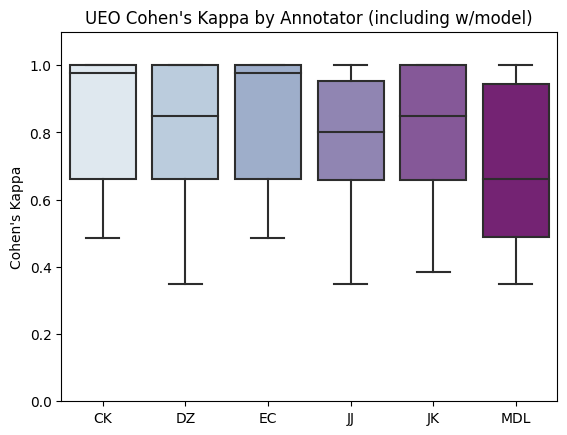

In [61]:

# max_length = max_length = max(len(arr) for arr in cln_annot_all_sz.values())
# plotting_array = np.full((max_length,len(cln_annot_all_sz)),np.nan)
# for i,arr in enumerate(cln_annot_all_sz.values()):
#     plotting_array[:len(arr),i] = arr
# plt.imshow(plotting_array)
plot_df = pd.DataFrame(ANNOT_ALL_SZ)
plot_df.columns = model_annotators
ax = sns.boxplot(plot_df)
plt.xticks(np.arange(len(model_annotators)),model_annotators)
plt.title("UEO Cohen's Kappa by Annotator (including w/model)")
plt.ylabel('Cohen\'s Kappa')
plt.ylim([0,1.1])
lst = model_annotators
# add_stat_annotation(ax,data=pd.DataFrame(ANNOT_ALL_SZ,columns=lst),box_pairs=[(lst[i], lst[j]) for i in range(len(lst)) for j in range(i+1, len(lst))],test='Mann-Whitney',loc='inside',verbose=0)
test_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(i+1, len(lst))]
for pair in test_pairs:
    res = sc.stats.mannwhitneyu(plot_df[pair[0]],plot_df[pair[1]])
    print(f"Comparing {pair}: {res}")

In [ ]:
# Getting all annots for each annot type combined into a tensor
all_seizures = []
for i,row in model_kappa_annots[[c for c in model_kappa_annots.columns if 'kappas' in c]].iterrows():
    # print(np.stack(row.to_numpy().tolist(),ax is=2).shape)
    temp = np.stack(row.to_numpy().tolist(),axis=2)
    temp[temp==2] = np.nan
    all_seizures.append(temp)
all_seizures = np.stack(all_seizures,axis=3)

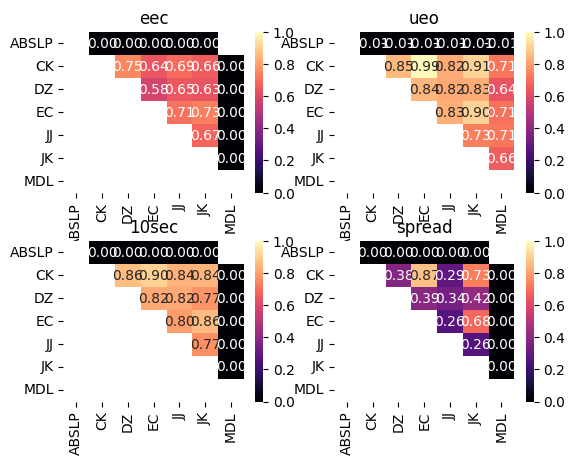

In [ ]:
# plotting the mean agreement per person per annotation type
all_seizure_means = np.mean(all_seizures,3)
titles = ["eec","ueo","10sec","spread"]
fig,axs = plt.subplots(2,2)
plt.subplots_adjust(hspace=.3)
for k in range(all_seizure_means.shape[2]):
    ax_idxs = np.unravel_index(k,(2,2))
    ax = axs[ax_idxs[0],ax_idxs[1]]
    sns.heatmap(all_seizure_means[:,:,k],annot=True,fmt=".2f",cmap="magma",xticklabels=model_annotators,yticklabels=model_annotators,vmin=0,vmax=1,ax=ax)
    ax.set_title(titles[k])

## Metadata summarization

examining metadata table

In [ ]:
lf_sz_metadata = sz_metadata[sz_metadata.Patient.isin(lf_pt_list)]
lf_sz_metadata.head(10)

,Patient,IEEGname,EEC,UEO,Other onset description,approximate,end,source,stim,stim_channels,EEC onset channels,UEO onset channels,Notes,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,HUP224,HUP224_phaseII,71156.5913,71156.58349,<NA>,71156.59,71190.99,Will manual,1.0,LB1-LB2,"LB1,LB2,LB3,LB4,LB5,LC1,LC2,LC3,LC4,LA1,LA2,LA...",<NA>,<NA>,<NA>,# Low frequency seizures,14.0,"plus 3 from redcap (HUP261, 263, 266)"
1,HUP224,HUP224_phaseII,202170.6825,202170.6825,<NA>,202170.68,202243.03,Erin manual,0.0,<NA>,<NA>,"RB2,RB3,RC2",<NA>,<NA>,# High frequency seizures,31.0,plus ??
2,HUP224,HUP224_phaseII,227267.9559,227267.9559,<NA>,227267.96,227350.65,Erin manual,0.0,<NA>,<NA>,"RB2,RB3,RC2",<NA>,<NA>,# Patients,34.0,"plus 3 from redcap (HUP261, 263, 266)"
3,HUP224,HUP224_phaseII,339135.7773,339143.6435,<NA>,339135.86,339234.20,Erin manual,0.0,<NA>,<NA>,"RB2,RB3,RC2",<NA>,<NA>,<NA>,<NA>,<NA>
4,HUP224,HUP224_phaseII,415736.83,415751.7187,<NA>,415736.98,415805.57,Erin manual,0.0,<NA>,<NA>,<NA>,no channels,<NA>,<NA>,<NA>,<NA>
5,HUP224,HUP224_phaseII,491462.5751,491467.8046,491466.1083,491462.51,491541.43,Erin manual,0.0,<NA>,"RB1,RB2","RB1,RB2,RB3,RB4",<NA>,<NA>,<NA>,<NA>,<NA>
6,HUP224,HUP224_phaseII,<NA>,<NA>,519177.9515,519177.95,519258.16,Erin manual,0.0,<NA>,<NA>,"RA1,RA2,RA3,RA4,RA5",<NA>,<NA>,<NA>,<NA>,<NA>
8,HUP225,HUP225_phaseII,159834.14,159834.14,<NA>,159833.84,159913.05,Erin manual,1.0,RC1-RC2,<NA>,"RB1,RB2,RB3,RB4",<NA>,<NA>,<NA>,<NA>,<NA>
9,HUP225,HUP225_phaseII,304819.9221,304944.5422,<NA>,304819.92,305031.85,Erin manual,0.0,<NA>,"RT4,RT5,RT6","RT4,RT5,RT6",<NA>,<NA>,<NA>,<NA>,<NA>
10,HUP225,HUP225_phaseII,309931.0256,309947.2112,<NA>,309931.03,310024.37,Erin manual,0.0,<NA>,"RT4,RT5,RT6",<NA>,"RT,RI,RU,RC,RB (UEO)",<NA>,<NA>,<NA>,<NA>


In [ ]:
def soz_union(row):
    # Takes in a row of metadata and caclulates the union of ueo and eec onset channels
    row.T
    if isinstance(row['EEC onset channels'],str):
        eec = set(row['EEC onset channels'].split(','))
    else:
        eec = set([])
    if isinstance(row['UEO onset channels'],str):
        ueo = set(row['UEO onset channels'].split(','))
    else:
        ueo = set([])
    return list(eec.union(ueo))
lf_sz_metadata['onset_channels'] = sz_metadata.apply(soz_union,axis=1)

In [ ]:
def pw_dice(group):
   pw_scores = []#np.zeros((len(group),len(group)),dtype=object)
   group = group[group.apply(lambda x:len(x)>0)]
   if len(group) > 0:
    for i in range(len(group)):
            for j in range(i+1,len(group)):
                pw_scores.append(dice_score(group.iloc[i],group.iloc[j]))
           
   return(pw_scores)

In [ ]:
# Goal is to get the dice score for each pairwise comparison. I want to add the distribution of pairwise dice scores for each group
all_scores = lf_sz_metadata.groupby('Patient')['onset_channels'].apply(pw_dice)
print(all_scores)

Patient
HUP224    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.57142857...
HUP225    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...
HUP230    [1.0, 0.6666666666666666, 0.6666666666666666, ...
HUP235    [1.0, 1.0, 1.0, 1.0, 0.8, 0.5714285714285714, ...
HUP238    [0.6666666666666666, 0.8571428571428571, 0.4, ...
HUP246                                                   []
HUP247    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1538461538461...
HUP249    [0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0,...
HUP250    [0.0, 0.0, 0.0, 0.0, 0.0, 0.47058823529411764,...
HUP253    [0.36363636363636365, 0.25, 0.3076923076923077...
HUP257    [0.46153846153846156, 0.6666666666666666, 0.42...
HUP263                                                   []
Name: onset_channels, dtype: object


## Single patient experimentation

In [ ]:
pt = "HUP235"
raw_datapath = ospj(datapath,pt)


In [ ]:
dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
else:
    final_drop_electrodes = []

In [ ]:
seizure_list = np.sort([s for s in os.listdir(ospj(raw_datapath, "seizures")) if 'preprocessed' in s])

In [ ]:
all_seizures = []
all_ts = []
for seizure_path in seizure_list:
    seizure_fs = pd.read_pickle(ospj(raw_datapath,"seizures",seizure_path))
    fs = seizure_fs.fs.to_numpy()[-1]
    seizure = seizure_fs.drop("fs",axis=1)
    cols = seizure.columns.to_list()
    clean_ch = [c for c in cols if c not in final_drop_electrodes]
    seizure = seizure.loc[:,clean_ch]
    t = np.arange(0,len(seizure)/fs,1/fs)
    all_ts.append(t)
    all_seizures.append(seizure)
    # plot_iEEG_data(seizure,t)


### SOZ

#### Electrode Agreement

In [ ]:
hup_no = pt[3:]
rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
recon_path =  ospj('/mnt','leif','littlab','data',
                        'Human_Data','recon','BIDS_penn',
                        f'sub-RID0{rid}','derivatives','ieeg_recon',
                        'module3/')
atropos_metadata = pd.read_json(recon_path + f'sub-RID0{rid}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
atropos_metadata.loc[:,['name']] = clean_labels(atropos_metadata.name,pt)
localization_probs = pd.read_json(recon_path + f'sub-RID0{rid}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
localization_probs.loc[:,['name']] = clean_labels(localization_probs.name,pt)



In [ ]:
def _apply_function(x):
    # look in labels sorted and see if it contains gray matter
    # if gray matter is greater than 5% then set label to gray matter
    x = pd.DataFrame(x).transpose()
    for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
        if (label != 'EmptyLabel') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
            x['label'] = label
            continue
        elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
            x['label'] = label
    return x

modified_regions = localization_probs.apply(_apply_function,axis=1)
modified_regions_df = pd.DataFrame(np.squeeze(np.array(modified_regions.to_list())),columns=localization_probs.columns)


In [ ]:
modified_regions_df.loc[10:25]

,name,x,y,z,index,label,labels_sorted,percent_assigned
10,LA11,22.7031,137.657,131.043,0,left middle temporal,"[EmptyLabel, left middle temporal ]","[0.5757575758, 0.4242424242]"
11,LA12,17.0517,137.965,131.18,0,EmptyLabel,[EmptyLabel],[1.0]
12,LB01,74.4941,127.331,134.158,17,left hippocampus,"[ left hippocampus , EmptyLabel]","[0.7575757576000001, 0.24242424240000002]"
13,LB02,69.4456,126.925,135.293,17,left hippocampus,[ left hippocampus ],[1.0]
14,LB03,63.8108,127.048,136.527,17,left hippocampus,[ left hippocampus ],[1.0]
15,LB04,58.1594,127.357,136.664,0,EmptyLabel,"[EmptyLabel, left hippocampus ]","[0.9696969697000001, 0.030303030300000002]"
16,LB05,52.5481,126.926,137.804,0,EmptyLabel,[EmptyLabel],[1.0]
17,LB06,47.4761,127.074,139.034,0,EmptyLabel,[EmptyLabel],[1.0]
18,LB07,41.8482,126.828,139.077,0,left middle temporal,"[EmptyLabel, left superior temporal , left m...","[0.48484848480000003, 0.2727272727, 0.24242424..."
19,LB08,36.2134,126.952,140.311,1015,left middle temporal,"[ left middle temporal , EmptyLabel]","[0.8484848485, 0.1515151515]"


In [ ]:
soz_ch = clean_labels(['LC1','LC2'],pt)
lf_soz_ch = clean_labels(['LI1', 'LI2', 'LA1', 'LA2', 'LB1', 'LB2', 'LB3', 'LB4', 'LC1', 'LC2', 'LC3'],pt)
hf_soz_ch = clean_labels(['LB1','LB2','LB3'],pt)

In [ ]:
dice_score(soz_ch,hf_soz_ch)


0.0

In [ ]:
soz_array = modified_regions_df.name.isin(soz_ch).to_numpy()
lf_soz_array = modified_regions_df.name.isin(lf_soz_ch).to_numpy()
hf_soz_array = modified_regions_df.name.isin(hf_soz_ch).to_numpy()

In [ ]:
def get_regions_from_channels(channels,regions_df):
    soz_region_labels = regions_df.loc[regions_df.name.isin(channels),['label']].to_numpy()
    soz_region_array = np.unique([r[0].strip() for r in soz_region_labels if r != 'EmptyLabel'])
    return soz_region_array

In [ ]:
soz_regions = get_regions_from_channels(soz_ch,modified_regions_df)
lf_regions = get_regions_from_channels(lf_soz_ch,modified_regions_df)
hf_regions = get_regions_from_channels(hf_soz_ch,modified_regions_df)
print(soz_regions,lf_regions,hf_regions)
print(dice_score(soz_regions,lf_regions))

['left hippocampus'] ['left amygdala' 'left hippocampus' 'left superior temporal'] ['left hippocampus']
0.5


#### Convex Hulls

In [ ]:
soz_coords = atropos_metadata.loc[atropos_metadata.name.isin(soz_ch),['x','y','z']]
soz_coords

lf_coords = atropos_metadata.loc[atropos_metadata.name.isin(lf_soz_ch),['x','y','z']]

hf_soz_coords = atropos_metadata.loc[atropos_metadata.name.isin(soz_ch),['x','y','z']]
hf_soz_coords

,x,y,z
24,67.2158,113.871,137.636
25,62.1673,113.465,138.771


In [ ]:
lf_hull = sc.spatial.ConvexHull(lf_coords)
lf_dhull = sc.spatial.Delaunay(lf_coords)
lf_intersect = lf_dhull.find_simplex(soz_coords) >=0

137.636


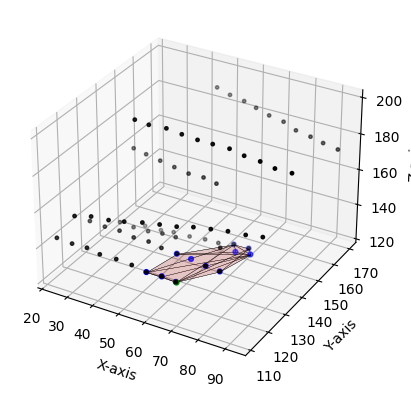

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
points = lf_coords.to_numpy()

# Plot all electrodes
all_contacts = atropos_metadata.loc[atropos_metadata.name.isin(clean_ch),['x','y','z']].to_numpy()
ax.scatter(all_contacts[:,0],all_contacts[:,1],all_contacts[:,2],"o",color="k",s=6)

# Plot the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], "o", color="b", s=12)

# Plot the convex hull's facets
for simplex in lf_hull.simplices:
    polygon = [lf_hull.points[i] for i in simplex]
    poly3d = [[vert[ix] for vert in polygon] for ix in range(3)]
    ax.plot_trisurf(*poly3d, color='r',edgecolor='k',linewidth=.2, alpha=0.1)
coords = soz_coords.to_numpy()[0]
print(coords[2])
ax.scatter(coords[0],coords[1],coords[2],"o",color='g',s=12)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

### Total Recruitment

#### Thresholding

(<Figure size 4414.97x1440 with 1 Axes>, <Axes: xlabel='Time (s)'>)

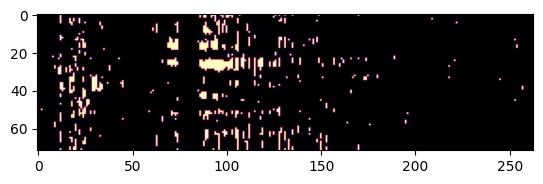

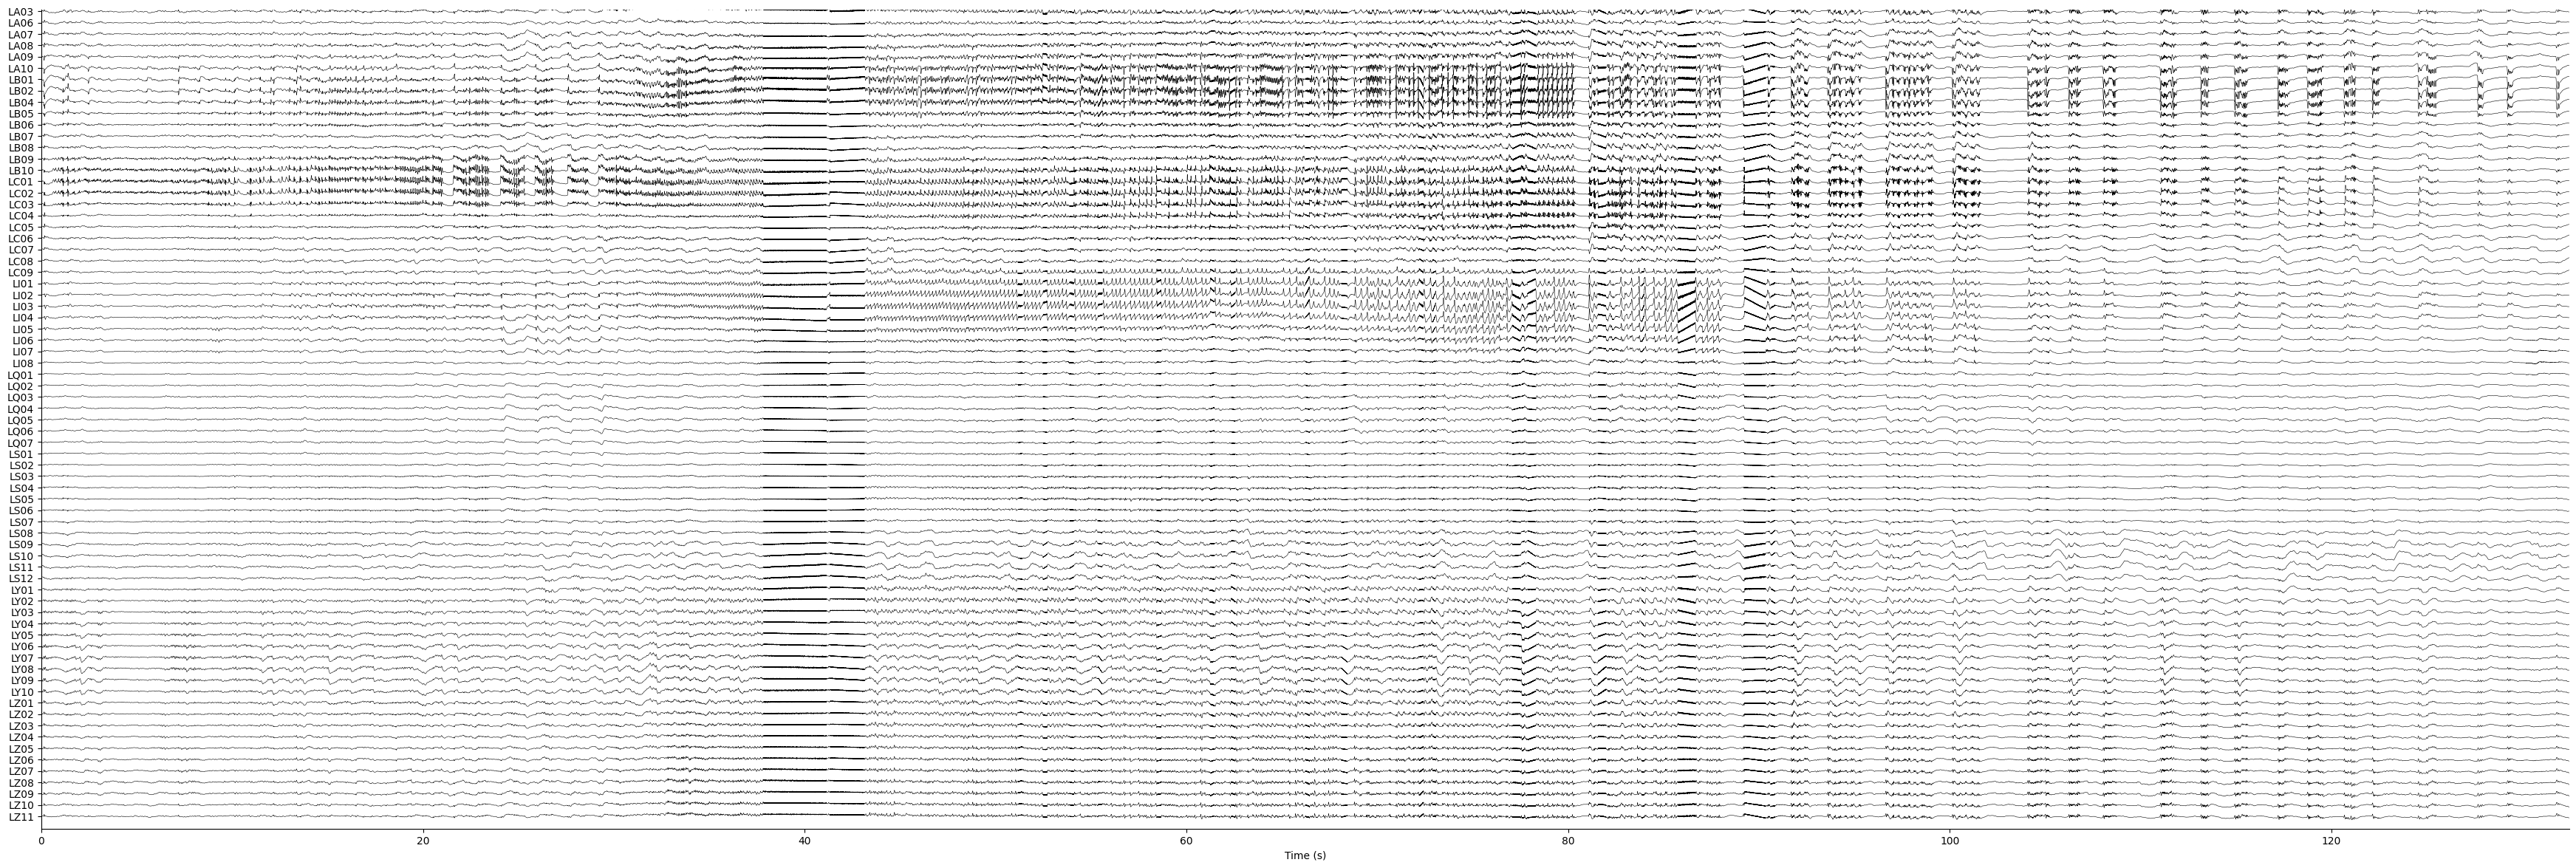

In [ ]:
n = 1
s = all_seizures[n]
t = all_ts[n]
ll_fun = lambda x: np.sum(np.abs(np.diff(x)),axis=-1)
def beta_fun(x):
    bps = bandpower(x,fs,win_size=1,win_stride=.5)
    return bps[:,1]
ft = ft_extract(s.to_numpy().T,fs,beta_fun,win_size=1,win_stride=.5)
ft_mask = ft > np.mean(ft) + 2*np.std(ft)
recruits = ft_mask.any(1)
plt.imshow(ft_mask)
plot_iEEG_data(s,t)

In [ ]:
def find_recruits(x):
    ll_fun = lambda x: np.sum(np.abs(np.diff(x)),axis=-1)
    def beta_fun(x):
        bps = bandpower(x,fs)
        return bps[:,4]
    ll = ft_extract(x.to_numpy().T,fs,ll_fun,win_size=1,win_stride=.5)
    ll_mask = ll > np.mean(ll) + 3*np.std(ll)
    recruits = ll_mask.any(1)
    recruit_chs = np.array(clean_ch)[recruits.flatten()]
    return recruit_chs

In [ ]:
seizure_keys = [int(s.split('_')[2]) for s in seizure_list]
seizure_keys = np.argsort(seizure_keys)
print(seizure_keys,seizure_list[seizure_keys])

[ 0  3  4  5  6  7  8  9 10 11  1  2] ['preprocessed_seizure_0_stim_1.pkl' 'preprocessed_seizure_1_stim_0.pkl'
 'preprocessed_seizure_2_stim_0.pkl' 'preprocessed_seizure_3_stim_0.pkl'
 'preprocessed_seizure_4_stim_0.pkl' 'preprocessed_seizure_5_stim_0.pkl'
 'preprocessed_seizure_6_stim_0.pkl' 'preprocessed_seizure_7_stim_0.pkl'
 'preprocessed_seizure_8_stim_0.pkl' 'preprocessed_seizure_9_stim_2.pkl'
 'preprocessed_seizure_10_stim_0.pkl' 'preprocessed_seizure_11_stim_0.pkl']


In [ ]:
all_recruited_chs = [find_recruits(x) for x in seizure_list[seizure_keys]]

AttributeError: 'numpy.str_' object has no attribute 'to_numpy'

In [ ]:
region_overlap_mat = np.zeros((len(all_seizures),len(all_seizures)))-1
for i in range(len(all_recruited_chs)):
    for j in range (i+1,len(all_recruited_chs)):
        score = dice_score(all_recruited_chs[i],all_recruited_chs[j])
        region_overlap_mat[i,j] = score


In [ ]:
region_color_mat = np.zeros((len(all_seizures),len(all_seizures)),dtype=str)
region_color_mat[0,:] = 'S'
region_color_mat[1:,:] = 'N'
region_color_mat

array([['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']],
      dtype='<U1')

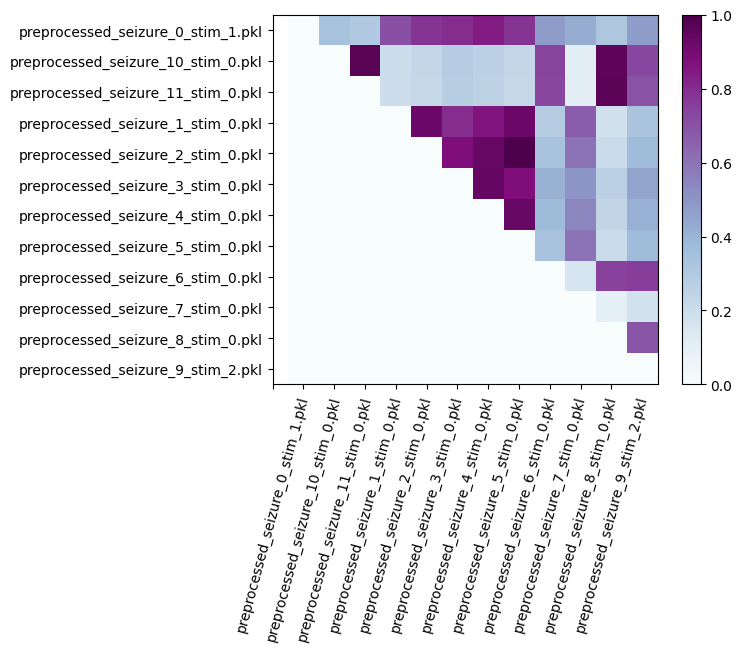

In [ ]:
_,ax = plt.subplots()
plt.imshow(region_overlap_mat)
plt.clim([0,1])
plt.colorbar()
plt.yticks(ticks = np.arange(len(seizure_list)),labels=seizure_list[seizure_keys]);
plt.xticks(ticks = np.arange(len(seizure_list))-1,labels=seizure_list[seizure_keys],rotation=75);


In [ ]:
mask = np.triu(np.ones_like(region_overlap_mat,dtype=bool),1)
region_overlap_array = region_overlap_mat[mask]
region_color_array = region_color_mat[mask]
category = ['1']*len(region_overlap_array)

<Axes: >

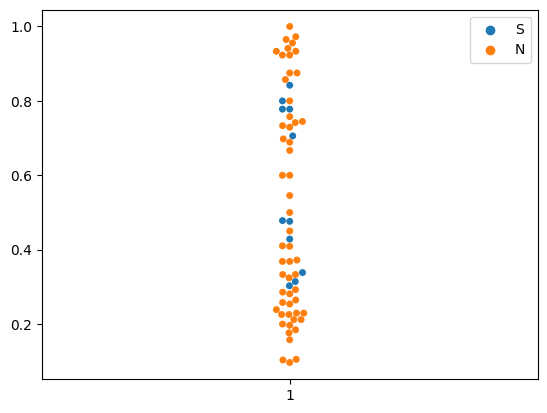

In [ ]:
sns.swarmplot(x=category,y=region_overlap_array,hue=region_color_array)